# 1. Set enviroment

In [1]:
# Select an interactive backend for plotting
# check all the options by: %matplotlib -l
%matplotlib -l

# I prefer to choose qt5 which will pop up a new window for each plot. 
# Here, for inline presentation, I choose nbagg.
%matplotlib nbagg
# %matplotlib qt5 

# Reload all modules everytime before executing the Python code typed. 
# Sometimes it didnot work. I will reload the script manually by 'reload(pe)'
%load_ext autoreload
%autoreload 2

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [3]:
import matplotlib.pylab as plt
import numpy as np
import os, glob, sys
from copy import deepcopy
sys.path.append('/Users/lakerhoo/AnacondaProjects/Github/Process_EELS_-Python-')
import process_EELS as pe
from importlib import reload
import json

# download lmfit for curve fitting
from lmfit.models import LinearModel, LorentzianModel, GaussianModel, ExponentialModel, PowerLawModel
from lmfit import Parameters

# 2. Load data

In [4]:
# Set the folder where your data is.
folder = '/Users/lakerhoo/Research/Gold_lollipop/Data/03_12_gold_lolipop/example_map/'
#folder = '/Users/your_user_name/your_folder_for_data'

# Get all the file names in the folder with a npy format. (I will save SI data in the numpy files.)
# You can change the loading function based on the file format only if the final outputs are numpy arrays.
os.chdir(folder)
file_names = sorted(glob.glob('*.npy')) #'sorted' sorts into alphabetical order
file_names = file_names[:]
for i, f in enumerate(file_names):
    print('{}: {}'.format(i,f))

# Load data into data_list and metadata into metadata_list.
# We will need the metadata files to recontruct the x-axis of the spectra.
# Here, for nionswift, we have .json files as metadata files.
data_list = []
x_list = []
for file in file_names:
    data_list.append(np.load(folder+file))
    with open(folder + file[:-4] +'.json') as json_data:
        metadata = json.load(json_data)
        scale = metadata['spatial_calibrations'][2]['scale']
        offset = metadata['spatial_calibrations'][2]['offset']
        x_list.append(np.linspace(0, data_list[0].shape[2]-1, data_list[0].shape[2]) * scale + offset)

new_data_list = []
for i in range(len(data_list)):
    new_data_list.append([x_list[i], data_list[i]])


0: 1.npy


In [82]:
def classify_by_heights(map1):
    """
    divide mapping into two regions (samples, substrates), based on the ZLP heights.
    """
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import normalize
    heights = np.array(map1.heights)
    thickmat = np.reshape(heights, [map1.pixel_num_x, map1.pixel_num_y])
    #divide the data into clusters based on kmeans the thickness
    sp = np.shape(thickmat)
    task = []
    for i in range(sp[0]):
        for j in range(sp[1]):
            task.append([i,j,thickmat[i,j]])
    t=np.array(task)

    t[np.isnan(t)]=0
    #t2=normalize(t,axis=0)
    t3=deepcopy(t)
    #t3[:,2]=t3[:,2]*4

    #num_clusters = get_k_number(task)
    num_clusters = 2
    estimator = KMeans(n_clusters=num_clusters)
    estimator.fit(t3)
    label_pred = estimator.labels_
    centroids = estimator.cluster_centers_ 
    #print('KMeans error: ',estimator.inertia_)
    lb = np.reshape(label_pred,np.shape(thickmat))
    label_points = []
    for i in range(sp[0]):
        for j in range(sp[1]):
            if lb[i,j] == np.argmax(centroids[:,2]):
                label_points.append([i, j])
    
    return centroids, lb, label_points


def find_center(centroids, lb, center):
    newlb = 0*lb
    p1, p2 = lb.shape
    t4 = []
    for i in range(p1):
        for j in range(p2):
            if lb[i,j] == np.argmax(centroids[:,2]):
                newlb[i,j] = 1
            t4.append([i,j,newlb[i,j]])
    # center = centroids[np.argmax(centroids[:,2]),:2]
    # center = [10,10]
    num_points = []
    tol = 0.05
    step = 1
    while True:
        radius = lb.shape[0] / 2
        is_stop = False
        while True:
            if radius < 1:
                is_stop = True
                print('Radius is 0. The center is far away from real center.')
                break
            new_list = []
            for i in t4:
                if (i[0] - center[0]) ** 2 + (i[1] - center[1]) ** 2 <= radius ** 2:
                    new_list.append(i)
            label_points = [[e[0], e[1]] for e in new_list if e[2] == 1] 
            label_ratio = np.sum(new_list, axis=0)[2] / len(new_list) 
            # print(len(label_points), label_ratio)
            if label_ratio > 1 - tol:
                num_points.append(len(label_points))
                break
            radius = radius - step
            
        center = np.sum(label_points, axis=0) / len(label_points)
        if len(num_points) >= 2:
            if abs(num_points[-1]/num_points[-2]-1) < tol/10:
                print('Optimal circle: center ({}), radius ({})'.format(center, radius))
                new_list = []
                for i in t4:
                    if (i[0] - center[0]) ** 2 + (i[1] - center[1]) ** 2 <= (0.6 * radius) ** 2:
                        new_list.append(i)
                label_points = [[e[0], e[1]] for e in new_list if e[2] == 1] 
                break
        if is_stop:
            break
        
    return center, radius, label_points

In [24]:
e.slice_data(xrange)

AttributeError: 'list' object has no attribute 'slice_data'

In [7]:
import time
reload(pe)
map_list = []
for i, e in enumerate(new_data_list):
    t1 = time.time()

    map1 = pe.Mapping()
    map1.set_initial_by_data(xdata=e[0], ydata=e[1])
    map1.align()
    map1.normalize_map()
    xrange = [0.3, 2]
    map1.slice_data(xrange)
    map1.PCA(6)
    map_list.append(map1)
    
    t2 = time.time()
    print("Job {} is finished in {} s".format(i, t2-t1))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [7]:
from shapely.geometry import MultiPoint
import time
spectra_list = []
for i, e in enumerate(data_list):
    t1 = time.time()
    map1 = map_list[i]
    centroids, lb, label_points = classify_by_heights(map1)
    points = MultiPoint(label_points)
    center0 = [int(points.representative_point().wkt[7:9]), int(points.representative_point().wkt[10:12])]
    # center = find_center_by_fitting(map1)
    center, radius, label_points = find_center(centroids, lb, center0)
    spectra_list.append(map1.select_sum_by_list(label_points))
    t2 = time.time()
    print("Job {} is finished in {} s".format(i, t2-t1))

Optimal circle: center ([18.39869281 18.80392157]), radius (7.0)
Job 0 is finished in 0.35773491859436035 s
Optimal circle: center ([18.39869281 18.80392157]), radius (7.0)
Job 1 is finished in 0.264066219329834 s
Optimal circle: center ([18.39869281 18.80392157]), radius (7.0)
Job 2 is finished in 0.28041911125183105 s
Optimal circle: center ([18.35064935 19.35064935]), radius (7.0)
Job 3 is finished in 0.4239077568054199 s
Optimal circle: center ([18.35064935 19.35064935]), radius (7.0)
Job 4 is finished in 0.4241979122161865 s
Optimal circle: center ([21.29787234 24.70212766]), radius (4.0)
Job 5 is finished in 0.23495793342590332 s
Optimal circle: center ([21.29787234 23.70212766]), radius (4.0)
Job 6 is finished in 0.234360933303833 s
Optimal circle: center ([21.73417722 23.3164557 ]), radius (5.0)
Job 7 is finished in 1.0525951385498047 s
Optimal circle: center ([21.58974359 23.42307692]), radius (5.0)
Job 8 is finished in 0.8132660388946533 s
Optimal circle: center ([21.58974359

In [16]:
import pickle
file_map = folder+'map_list.xhu'
f = open(file_map, 'wb')
pickle.dump(map_list,f)
f.close()

In [17]:
import pickle
file_map = folder+'map_list.xhu'
f = open(file_map, 'rb')
map1 = pickle.load(f)
f.close()

In [19]:
0

0

In [20]:
file_sp = folder+'spectra_list.xhu'
f = open(file_sp, 'wb')
pickle.dump(spectra_list,f)
f.close()

In [124]:
import time
i=10
e=data_list[10]
t1 = time.time()
scale = data_json_list[i]['spatial_calibrations'][2]['scale']
offset = data_json_list[i]['spatial_calibrations'][2]['offset']
x = np.linspace(0, data_list[0].shape[2]-1, data_list[0].shape[2]) * scale + offset

map1 = Mapping()
map1.set_initial_by_data(xdata=x, ydata=e)
map1.main()
xrange = [0.3, 2]
map1.slice_data(xrange)
map1.PCA(6)

t2 = time.time()
print("Job {} is finished in {} s".format(i, t2-t1))

Job 10 is finished in 57.449647188186646 s


In [125]:
plt.figure()
map1.elements[0].plot()

In [419]:
plt.figure()
plt.imshow(np.reshape(map_list[5].heights, [50,50]))

In [76]:
data_json_list[0]

{'version': 1,
 'reader_version': 1,
 'spatial_calibrations': [{'offset': -150.0, 'scale': 7.5, 'units': 'nm'},
  {'offset': -150.0, 'scale': 7.5, 'units': 'nm'},
  {'offset': -0.24741999999999925,
   'scale': 0.0012296000000000013,
   'units': 'eV'}],
 'intensity_calibration': {'offset': 0.0, 'scale': 1.0, 'units': 'counts'},
 'collection_dimension_count': 2,
 'datum_dimension_count': 1,
 'metadata': {'scan_detector': {'autostem': {'ImageScanned:C1 ConstW': 0.342,
    'ImageScanned:C10': 0.0,
    'ImageScanned:C12.a': 1.90052e-10,
    'ImageScanned:C12.b': -9.33935e-11,
    'ImageScanned:C21.a': -9.10181e-08,
    'ImageScanned:C21.b': -4.88781e-08,
    'ImageScanned:C23.a': 1.97283e-08,
    'ImageScanned:C23.b': -9.25201e-08,
    'ImageScanned:C30': -1.25737e-05,
    'ImageScanned:C32.a': -1.44123e-06,
    'ImageScanned:C32.b': 7.08873e-07,
    'ImageScanned:C34.a': 2.38239e-06,
    'ImageScanned:C34.b': 6.89161e-07,
    'ImageScanned:C41.a': 0.000143904,
    'ImageScanned:C41.b': 7.7

In [422]:
#test clustering
i=35
heights = np.array(map_list[-1].heights)
thickmat = np.reshape(heights, [map_list[-1].pixel_num_x, map_list[i].pixel_num_y])
plt.subplots(1,2,figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(thickmat)
plt.subplot(1,2,2)
# lb=np.reshape(label_pred,np.shape(thickmat))
plt.imshow(lb)
ax = plt.gca()
circle = plt.Circle(center, 0.6*radius, color='r', fill=False)
ax.add_artist(circle)

In [74]:
plt.figure()
plt.plot(data_list[10][0,0,:])

In [39]:
spectra_list = []
import time
for i, e_map in enumerate(map_list):
    t1 = time.time()
    centroids, lb = classify_by_heights(e_map)
    center, radius, label_points = find_center(centroids, lb)
    spectra_list.append(e_map.select_sum_by_list(label_points))
    t2 = time.time()
    print("Job {} is finished in {} s".format(i, t2-t1))

Optimal circle: center ([18.62285714 19.41142857]), radius (7.499999999999975)


AttributeError: 'Mapping' object has no attribute 'select_sum_by_list'

In [255]:
line = Line([x, data[0,0]])
zlp_xrange = [min(x),0.5]

In [256]:
line.sub_by_power_law([0.2616,0.3938], [0.5, 2])

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [220]:
from scipy.interpolate import UnivariateSpline
y_spline = UnivariateSpline(line.data[0],line.data[1],s=0,k=3)
zlp_range = np.linspace(zlp_xrange[0],zlp_xrange[1],10000)
shift, height = zlp_range[np.argmax(y_spline(zlp_range))], max(y_spline(zlp_range))

<IPython.core.display.Javascript object>


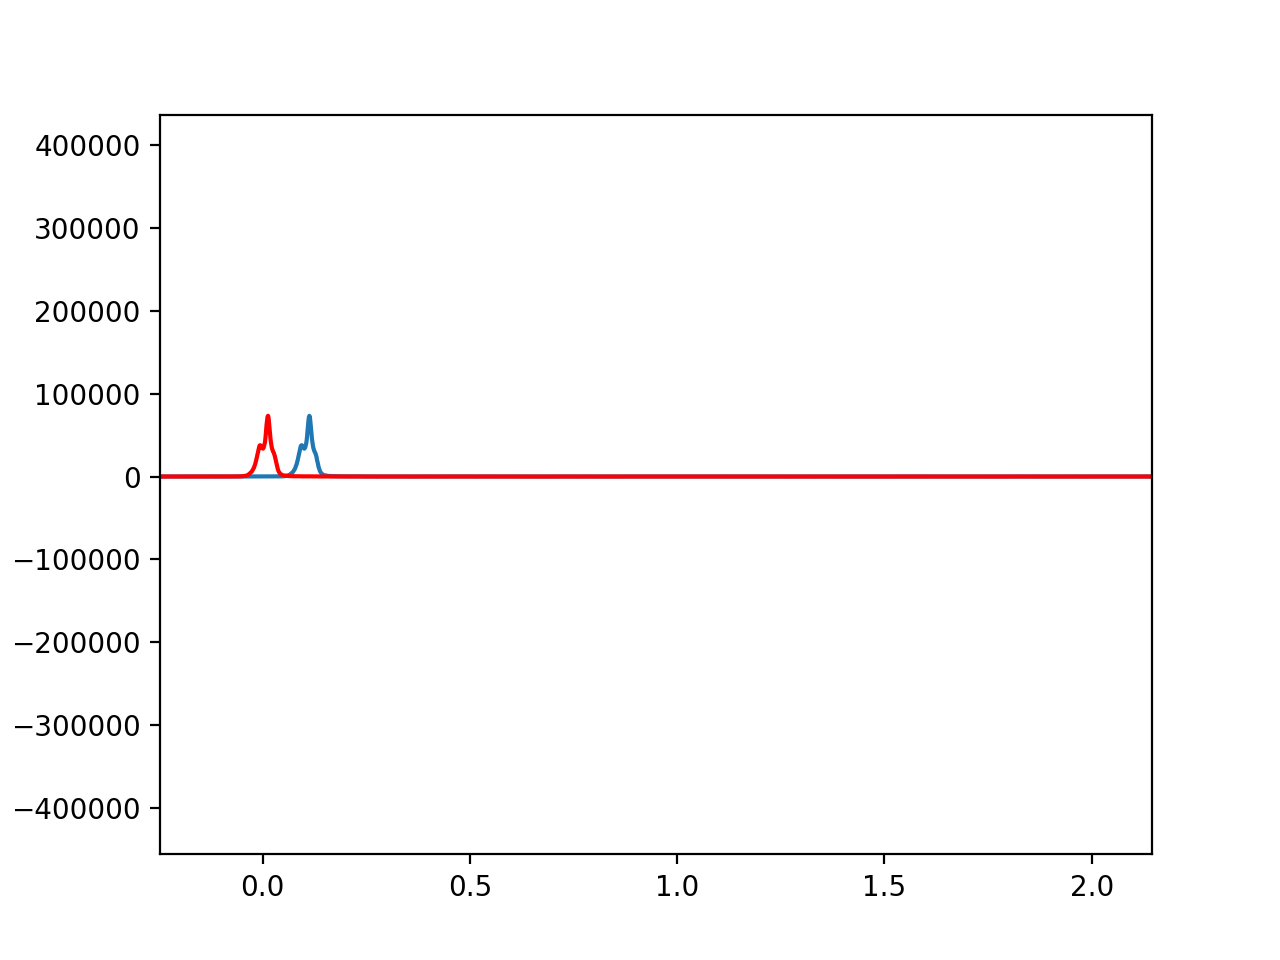

(-0.24741999999999925, 2.1695712000000036)

In [228]:
plt.figure()
plt.plot(x, y_spline(x))
plt.plot(x, y_spline(x+0.1),'r')
plt.xlim([min(x), max(x)-0.1])

In [267]:
lmfi

In [261]:
model.eval

<bound method CompositeModel.eval of <lmfit.Model: (Model(powerlaw) + Model(linear))>>

<IPython.core.display.Javascript object>


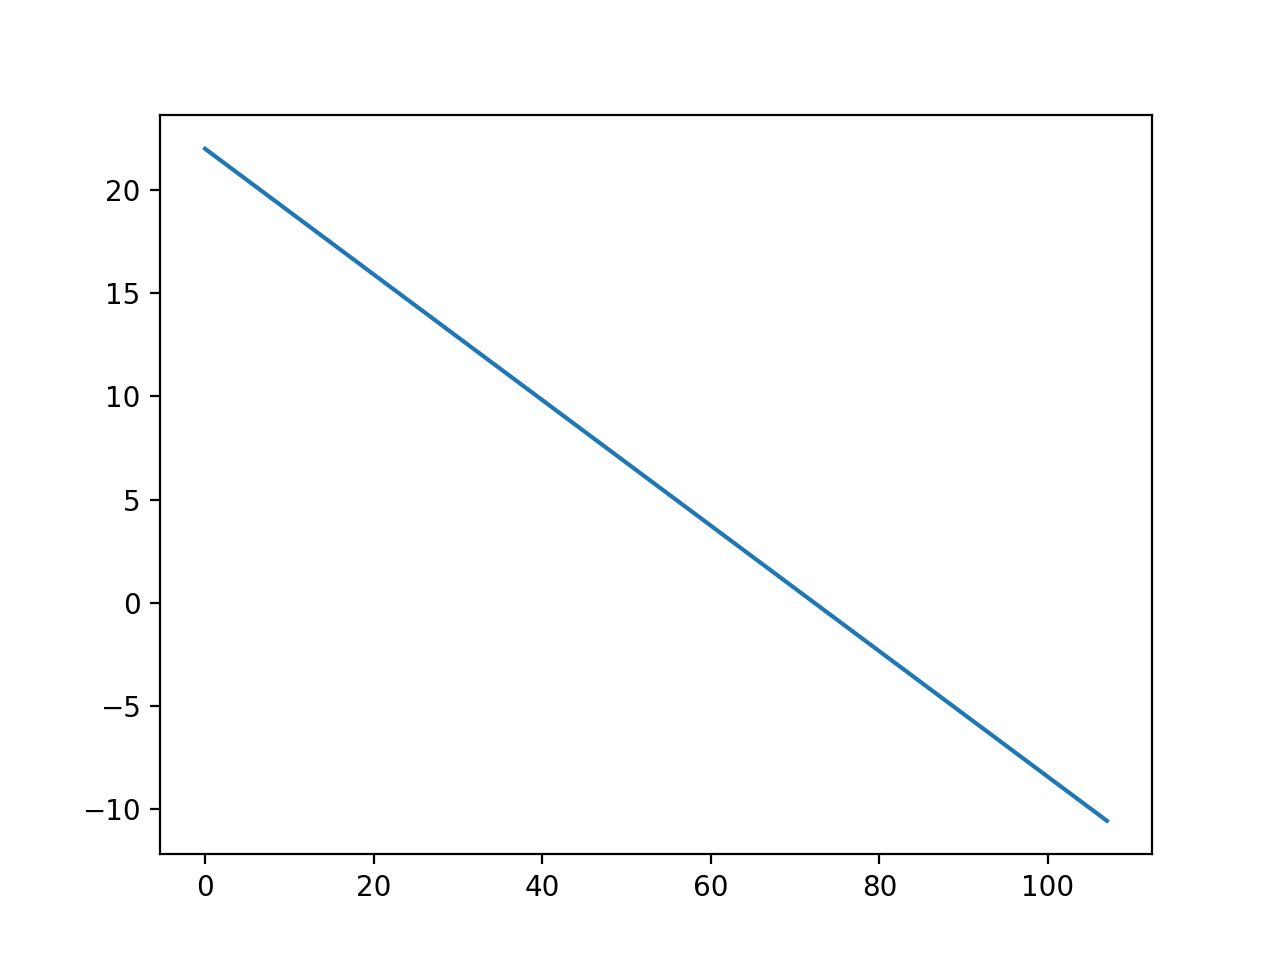

In [268]:
plt.figure()
plt.plot(result.eval())

In [77]:
data_json_list[0]

{'version': 1,
 'reader_version': 1,
 'spatial_calibrations': [{'offset': -150.0, 'scale': 7.5, 'units': 'nm'},
  {'offset': -150.0, 'scale': 7.5, 'units': 'nm'},
  {'offset': -0.24741999999999925,
   'scale': 0.0012296000000000013,
   'units': 'eV'}],
 'intensity_calibration': {'offset': 0.0, 'scale': 1.0, 'units': 'counts'},
 'collection_dimension_count': 2,
 'datum_dimension_count': 1,
 'metadata': {'scan_detector': {'autostem': {'ImageScanned:C1 ConstW': 0.342,
    'ImageScanned:C10': 0.0,
    'ImageScanned:C12.a': 1.90052e-10,
    'ImageScanned:C12.b': -9.33935e-11,
    'ImageScanned:C21.a': -9.10181e-08,
    'ImageScanned:C21.b': -4.88781e-08,
    'ImageScanned:C23.a': 1.97283e-08,
    'ImageScanned:C23.b': -9.25201e-08,
    'ImageScanned:C30': -1.25737e-05,
    'ImageScanned:C32.a': -1.44123e-06,
    'ImageScanned:C32.b': 7.08873e-07,
    'ImageScanned:C34.a': 2.38239e-06,
    'ImageScanned:C34.b': 6.89161e-07,
    'ImageScanned:C41.a': 0.000143904,
    'ImageScanned:C41.b': 7.7

In [181]:
# Compare #1 - #5
sel = [0, 10, 30, 40, 45]
new_lines = [spectra_list[i] for i in sel]
# Example Task 1: set parameters and plot raw data

# set range to display and colors of lines
figsize = (8,8)
xrange = [0.3, 2]
prop_cycle = plt.rcParams['axes.prop_cycle'] # default colors
colors = prop_cycle.by_key()['color']
data_list = deepcopy(new_lines)
yshift_list = np.linspace(0, len(data_list)-1, len(data_list)) * (-0.6)
label_list = ['#1', '#2', '#3','#4','#5']
color_list = colors[:len(data_list)]

config = {'xrange' : xrange,
          'yshift_list' : yshift_list,
          'label_list' : label_list,
          'color_list' : color_list}

linefigure = LineDisplay(figsize, config)
linefigure.set_initial_lines([Line(data, label_list[i]) for i, data in enumerate(data_list)])
linefigure.make_plot()

# Save
#plt.savefig('2.5um_3um_rod_sub.png', bbox_inches='tight')

[8.124231315561849e-06, -3.858558308897852e-05, -8.523915761752754e-05, -0.00013386024731111773, -0.00017824553179391465]


In [24]:
# Compare #1 with different #2
sel = [0, 1, 2, 3, 4] + [i for i in range(10,30)]
new_lines = [spectra_list[i] for i in sel]
# Example Task 1: set parameters and plot raw data

# set range to display and colors of lines
figsize = (8,8)
xrange = [0.3, 2]
prop_cycle = plt.rcParams['axes.prop_cycle'] # default colors
colors = prop_cycle.by_key()['color']
data_list = deepcopy(new_lines)
yshift_list = np.linspace(0, len(data_list)-1, len(data_list)) * (-0.6)
#label_list = ['#1', '#2-1', '#2-2','#2-3','#2-4']
label_list = [''] * len(data_list)
color_list = colors[:len(data_list)]

config = {'xrange' : xrange,
          'yshift_list' : yshift_list,
          'label_list' : label_list,
          'color_list' : color_list,
          'smooth_degree' : 100,
          'display_find_peak' : True}

linefigure = LineDisplay(figsize, config)
linefigure.set_initial_lines([Line(data, label_list[i]) for i, data in enumerate(data_list)])
linefigure.find_peak()
#linefigure.make_plot()

# Save
#plt.savefig('2.5um_3um_rod_sub.png', bbox_inches='tight')

Peak positions for : [0.4725 0.6865 1.0685 1.371  1.5005 1.697 ]
Height : [3.52801821e-05 5.97469211e-05 5.85788550e-05 4.12522577e-05
 5.31677477e-05 3.99337656e-05]
Peak positions for : [0.687  1.068  1.3735 1.5025 1.6935]
Height : [6.10028133e-05 5.69891378e-05 4.18256976e-05 5.10554280e-05
 3.85016895e-05]
Peak positions for : [0.6845 1.072  1.3735 1.5055 1.698 ]
Height : [6.10780953e-05 5.62549762e-05 4.14518160e-05 5.15980596e-05
 3.71608466e-05]
Peak positions for : [0.433  0.684  1.0715 1.3735 1.5085 1.696 ]
Height : [3.55734800e-05 5.86178190e-05 5.56962284e-05 3.98895257e-05
 5.02071844e-05 3.68376270e-05]
Peak positions for : [0.686  1.0685 1.379  1.5005 1.69  ]
Height : [5.99602495e-05 5.68866957e-05 4.19507707e-05 5.04520352e-05
 3.77844301e-05]
Peak positions for : [0.472  0.688  1.0805 1.398  1.5325 1.7285]
Height : [3.08156470e-05 5.30208542e-05 4.64885749e-05 3.13478739e-05
 4.36227782e-05 3.28422913e-05]
Peak positions for : [0.6875 1.082  1.393  1.5325 1.737 ]
Height

/Users/lakerhoo/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [41]:
peak_mat = []
for peaks in linefigure.peak_positions:
    a = np.array(peaks)
    peak_mat.append(list(a[a>0.6]))
label = ['#1', '#2_1', '#2_2', '#2_3', '#2_4']
label_type = ['#1', '#2', '#2', '#2', '#2']
for i in range(25):
    peak_mat[i].append(label[i//5])
    peak_mat[i].append(label_type[i//5])

In [220]:
# del_list = [0, 3, 5, 12, 16, 17, 18, 20, 21, 22]
del_list2 = [18]
for i in del_list2:
    linefigure.peak_positions[i] = np.delete(linefigure.peak_positions[i],0)

In [42]:
import pandas as pd
data = pd.DataFrame(peak_mat, columns=['Peak1', 'Peak2', 'Peak3', 'Peak4', 'Peak5','group','type'])
label_peak = ['Peak1', 'Peak2', 'Peak3', 'Peak4', 'Peak5']
for i in range(5):
    data.boxplot(label_peak[i], by='group', figsize=(12, 8))
    ymean = data[label_peak[i]].values.mean()
    height = 0.06
    plt.ylim(ymean-height*1/2, ymean+height*1/2)
    if i in [2,3,4]:
        plt.ylim(ymean-height*2/3, ymean+height*1/3)



In [48]:
from scipy import stats
import seaborn as sns
stat_list = []
for i in range(5):
    peak_list = []
    for j in range(5):
        peak_list.append(data[data['group'] == label[j]][label_peak[i]].values)
    stat_list.append(peak_list)


In [45]:
0

0

In [487]:
fs=20
for j in range(1,2):
#j=2
    plt.figure(figsize=[8,4])
    heights = []
    for i in range(5):
        ax = sns.distplot(stat_list[j][i],label=label[i], norm_hist=False)
        # heights.append(max([h.get_height() for h in ax.patches]))
        heights.append(max(ax.get_lines()[i].get_data()[1]))
        #plt.legend(fontsize=fs-5)
    plt.ylim([0, np.sort(heights)[-1]*1.1])
    plt.title(label_peak[j], fontsize=fs)
    ymean = data[label_peak[j]].values.mean()
    height = 0.06
    plt.xlim(ymean-height*1/2, ymean+height*1/2)
    plt.xticks(fontsize=fs-5)
    plt.xlabel('Peak Position (eV)', fontsize=fs)
    plt.yticks([])
    plt.ylabel('Counts', fontsize=fs)
    if j in [2,3,4]:
        plt.xlim(ymean-height*2/3, ymean+height*1/3)
    plt.savefig(folder+'distplot_'+label_peak[j]+'.svg', bbox_inches='tight')

In [456]:
ax.get_lines()

<a list of 5 Line2D objects>

In [431]:
i=0;
j=0;
plt.figure()
ax = sns.distplot(stat_list[j][i],label=label_type[i], norm_hist=False)
max([h.get_height() for h in ax.patches])

399.9999999999849

In [399]:
pd_peak = []
for num_peak in range(5):
    pd_peak.append(pd.DataFrame(np.transpose(np.array(stat_list[num_peak])),columns=label))

In [407]:
for e in label:
    sns.distplot(pd_peak[2][e])

In [409]:
pd_peak[2].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ca5fee470>,
      dtype=object)

In [60]:
pvalue_map = np.zeros([5,5])
for j in range(5):
    plt.figure()
    for i in range(5):
        for ii in range(5):
            pvalue_map[i,ii] = stats.ttest_ind(stat_list[j][i], stat_list[j][ii], equal_var = False).pvalue
    ax = sns.heatmap(pvalue_map>0.01, xticklabels=label, yticklabels=label)
    ax.xaxis.set_ticks_position('top')
    plt.title('p-values for '+label_peak[j])
    plt.savefig('p_values_'+label_peak[j]+'.svg', bbox_inches='tight')

In [47]:
pvalue_map

array([[1.00000000e+00, 2.60911653e-08, 2.60911653e-08, 2.60911653e-08,
        2.60911653e-08],
       [2.60911653e-08, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [2.60911653e-08, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [2.60911653e-08, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [2.60911653e-08, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00]])

In [364]:
stats.ttest_ind(stat_list[j][3], stat_list[j][4])

Ttest_indResult(statistic=-1.286124467344136, pvalue=0.23437172165789558)

In [356]:
pvalue=[]
for j in range(5):
    pvalue.append(stats.ttest_ind(stat_list[j][0], stat_list[j][1]).pvalue)
pvalue

[0.008722420582779646,
 2.284027188235429e-06,
 2.5755579918969653e-06,
 7.055127272610364e-08,
 1.0050697106445967e-07]

In [224]:
import pandas as pd
data = pd.DataFrame(peak_mat)
 
#Create a boxplot
data.boxplot('weight', by='group', figsize=(12, 8))
 
ctrl = data['weight'][data.group == 'ctrl']

grps = pd.unique(data.group.values)
d_data = {grp:data['weight'][data.group == grp] for grp in grps}
 
k = len(pd.unique(data.group))  # number of conditions
N = len(data.values)  # conditions times participants
n = data.groupby('group').size()[0]

KeyError: 'group'

In [427]:
# Compare #1 with different #2
sel = [0, 25]
new_lines = [spectra_list[i] for i in sel]
# Example Task 1: set parameters and plot raw data

# set range to display and colors of lines
figsize = (8,2)
xrange = [0.3, 2]
prop_cycle = plt.rcParams['axes.prop_cycle'] # default colors
colors = prop_cycle.by_key()['color']
data_list = deepcopy(new_lines)
yshift_list = np.linspace(0, len(data_list)-1, len(data_list)) * (-0.8)
label_list = ['#1', '#2']
color_list = [colors[0], colors[4]] #colors[:len(data_list)]

config = {'xrange' : xrange,
          'yshift_list' : yshift_list,
          'label_list' : label_list,
          'color_list' : color_list,
          'smooth_degree' : 100,
          'display_find_peak' : True}

linefigure = LineDisplay(figsize, config)
linefigure.set_initial_lines([Line(data, label_list[i]) for i, data in enumerate(data_list)])
linefigure.find_peak()
linefigure.make_plot()

# Save
#plt.savefig('2.5um_3um_rod_sub.png', bbox_inches='tight')

Peak positions for #1: [0.4725 0.6865 1.0685 1.371  1.5005 1.697 ]
Height #1: [3.52801821e-05 5.97469211e-05 5.85788550e-05 4.12522577e-05
 5.31677477e-05 3.99337656e-05]
Peak positions for #2: [0.4155 0.6905 1.079  1.407  1.53   1.736 ]
Height #2: [3.06499412e-05 5.26021608e-05 4.75241730e-05 3.45842268e-05
 4.59443966e-05 3.47923016e-05]


[8.124231315561849e-06, -5.449177322383309e-05]


/Users/lakerhoo/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [168]:
linefigure.elements[0].data

[array([0.3009816, 0.3022112, 0.3034408, ..., 1.9966   , 1.9978296,
        1.9990592]),
 array([4.62558060e-05, 4.64080282e-05, 4.70565473e-05, ...,
        1.27285985e-05, 1.50339452e-05, 1.38506692e-05])]

In [199]:
def new_PCA_plot(self, file_prefix=''):
    import matplotlib.gridspec as gridspec
    for i in range(self.PCA_ncomps):
        self.PCA_coefficients[i] = np.reshape(self.PCA_coefficients[i], [self.pixel_num_x, self.pixel_num_y])
        plt.figure(figsize=[8,3])
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 6]) 
        ax0 = plt.subplot(gs[0])
        plt.imshow(self.PCA_coefficients[i])
        ax1 = plt.subplot(gs[1])
        plt.plot(self.PCA_components[i][0], self.PCA_components[i][1])
        plt.xlabel('Energy Loss (eV)')
        plt.tight_layout()
        plt.savefig(file_prefix+'PCA_#{}.png'.format(i), bbox_inches='tight')

In [63]:
folder = '/Users/lakerhoo/Research/Quasiparticle/Data/04_16_quasicrystal_stat_map/'
sel = [0, 10, 15, 20, 25]
name_list = ['Type1', 'Type2', 'Type2_2', 'Type2_3', 'Type2_4']
for i, e in enumerate(sel):
    map_list[e].PCA_plot(file_prefix=folder+name_list[i]+'_')

In [62]:
folder = '/Users/lakerhoo/Research/Quasiparticle/Data/04_16_quasicrystal_stat_map/'
sel = [30, 40, 45, 5, 35]
name_list = ['Type3', 'Type4', 'Type5', 'Type1C', 'Type3C']
for i, e in enumerate(sel):
    map_list[e].PCA_plot(file_prefix=folder+name_list[i]+'_')

/Users/lakerhoo/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [56]:
import time
i=10
e=data_list[10]
t1 = time.time()
scale = metadata_list[i]['spatial_calibrations'][2]['scale']
offset = metadata_list[i]['spatial_calibrations'][2]['offset']
x = np.linspace(0, data_list[0].shape[2]-1, data_list[0].shape[2]) * scale + offset

map1 = Mapping()
map1.set_initial_by_data(xdata=x, ydata=e)
map1.main()
xrange = [0.3, 2]
map1.slice_data(xrange)
t2 = time.time()
print("Job {} is finished in {} s".format(i, t2-t1))

Job 10 is finished in 51.33293700218201 s


In [60]:
from shapely.geometry import MultiPoint
t1 = time.time()
centroids, lb, label_points = classify_by_heights(map1)
points = MultiPoint(label_points)
center0 = [int(points.representative_point().wkt[7:9]), int(points.representative_point().wkt[10:12])]
# center = find_center_by_fitting(map1)
center, radius, label_points = find_center(centroids, lb, center0)
spectra = map1.select_sum_by_list(label_points)
t2 = time.time()
print("Job {} is finished in {} s".format(i, t2-t1))

Optimal circle: center ([24.4551495  25.22259136]), radius (10.0)
Job 10 is finished in 0.8699710369110107 s


In [125]:
line1 = Line(spectra)
xrange = [0.3, 2]
line1.data = line1.slice_data(xrange)
xs, ys = line1.smooth_PCA(dE=0.021)
xss, yss = line1.smooth(31)

Smooth by PCA.
Setting dE block: 0.021 ev. Real dE: 0.020903199999999955 eV
(1366, 1) (1, 17)


In [126]:
plt.figure()
plt.plot(spectra[0], spectra[1], 'b')
plt.plot(xs, ys, 'k')
plt.plot(xss, yss, 'r--')

In [113]:
ys.shape

(1366,)

In [91]:
xs.shape

(1366,)

In [106]:
int(13/2)

6